In [13]:
# Ignorar advertencias generales
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [14]:
def set_seed(seed):
    # Fijar semilla para TensorFlow
    tf.random.set_seed(seed)
    # Fijar semilla para NumPy
    np.random.seed(seed)
    # Fijar semilla para random (nativo de Python)
    random.seed(seed)
    # Opcional: Asegurar reproducibilidad en operaciones paralelas de TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para reproducibilidad en hash
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Operaciones determinísticas en TensorFlow

set_seed(40)  # Establece una semilla fija

## Carga y Exploración de los Datos

In [15]:

# Cargar datos
X_train = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")
X_test_knn = pd.read_csv(r"../Datos/BinarioTest2Balanced.csv")

In [16]:
def process_data(dataset, dataset_name):
    """
    Procesa un conjunto de datos separando características y etiquetas, 
    y calcula la distribución de clases.

    Parameters:
        dataset (pd.DataFrame): El conjunto de datos con características y etiquetas.
        dataset_name (str): Nombre del conjunto de datos (entrenamiento o prueba).

    Returns:
        X (np.ndarray): Características del conjunto de datos.
        Y (np.ndarray): Etiquetas del conjunto de datos.
    """
    print(f"\n\t\tDistribución de clases en {dataset_name}")
    nr_clases = dataset['CLASS_LABEL'].value_counts(sort=True)
    porcentajes = nr_clases * 100 / dataset.shape[0]
    distribucion = pd.DataFrame({'Cantidad': nr_clases, 'Porcentaje (%)': porcentajes})
    print(distribucion)

    # Separar características y etiquetas
    Y = dataset['CLASS_LABEL'].values
    X = dataset.drop(['CLASS_LABEL'], axis=1).values
    return X, Y


# Procesar conjuntos de datos
X_train, Y_train = process_data(X_train, "entrenamiento")
X_test, Y_test = process_data(X_test, "prueba AE")
X_test_knn, Y_test_knn = process_data(X_test_knn, "prueba Knn")

# Imprimir dimensiones de los conjuntos
print("\nDimensiones de los conjuntos:")
print(f"Entrenamiento: {X_train.shape}, {Y_train.shape}")
print(f"Prueba AE: {X_test.shape}, {Y_test.shape}")
print(f"Prueba Knn: {X_test_knn.shape}, {Y_test_knn.shape}")


		Distribución de clases en entrenamiento
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
0                6212       50.064475
1                6196       49.935525

		Distribución de clases en prueba AE
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
0                 777       50.096712
1                 774       49.903288

		Distribución de clases en prueba Knn
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
1                 785       50.612508
0                 766       49.387492

Dimensiones de los conjuntos:
Entrenamiento: (12408, 606), (12408,)
Prueba AE: (1551, 606), (1551,)
Prueba Knn: (1551, 606), (1551,)


In [17]:
# Convertir los conjuntos de datos a tensores
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.int32)

X_test_tensor_ae = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tensor_ae = tf.convert_to_tensor(Y_test, dtype=tf.int32)

X_test_tensor_knn = tf.convert_to_tensor(X_test_knn, dtype=tf.float32)
Y_test_tensor_knn = tf.convert_to_tensor(Y_test_knn, dtype=tf.int32)

# Imprimir los tamaños de los tensores
print("\nTamaños de los tensores:")
print(f"X_train_tensor: {X_train_tensor.shape}, Y_train_tensor: {Y_train_tensor.shape}")
print(f"X_test_tensor_ae: {X_test_tensor_ae.shape}, Y_test_tensor_ae: {Y_test_tensor_ae.shape}")
print(f"X_test_tensor_knn: {X_test_tensor_knn.shape}, Y_test_tensor_knn: {Y_test_tensor_knn.shape}")


Tamaños de los tensores:
X_train_tensor: (12408, 606), Y_train_tensor: (12408,)
X_test_tensor_ae: (1551, 606), Y_test_tensor_ae: (1551,)
X_test_tensor_knn: (1551, 606), Y_test_tensor_knn: (1551,)


## Entrenamos el modelo

In [18]:
# Parámetros configurables
input_dim = 606  # Dimensión de entrada
embedding_dim = 20  # Dimensión final de los embeddings
hidden_units = [128, 64]  # Capas ocultas intermedias

# Configurar modelo de embeddings
embedding_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(input_dim,), name="Input_Layer"),
        tf.keras.layers.Dense(
            hidden_units[0],
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            name="Dense_Layer_1",
        ),
        tf.keras.layers.Dense(
            hidden_units[1],
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            name="Dense_Layer_2",
        ),
        tf.keras.layers.Dense(
            embedding_dim,
            activation=None,  # No activación final, embeddings crudos
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            name="Embedding_Layer",
        ),
        tf.keras.layers.Lambda(
            lambda x: tf.math.l2_normalize(x, axis=-1), name="L2_Normalization"
        ),  # Normalización L2
    ],
    name="Embedding_Model",
)

# Configurar pérdida de tripletas
loss_fn = tfa.losses.TripletSemiHardLoss(margin=1.0)

# Compilar el modelo
embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_fn
)

# Resumen del modelo
embedding_model.summary()


Model: "Embedding_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_Layer_1 (Dense)       (None, 128)               77696     
                                                                 
 Dense_Layer_2 (Dense)       (None, 64)                8256      
                                                                 
 Embedding_Layer (Dense)     (None, 20)                1300      
                                                                 
 L2_Normalization (Lambda)   (None, 20)                0         
                                                                 
Total params: 87252 (340.83 KB)
Trainable params: 87252 (340.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:

# Configuración de callbacks para mejorar el entrenamiento
early_stopping = EarlyStopping(
    monitor="loss",  # Métrica a monitorear
    patience=10,      # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos del modelo
)

reduce_lr = ReduceLROnPlateau(
    monitor="loss",  # Métrica a monitorear
    factor=0.5,      # Factor para reducir el learning rate
    patience=10,     # Número de épocas sin mejora antes de reducir el learning rate
    min_lr=1e-6      # Learning rate mínimo permitido
)

# Entrenamiento del modelo
batch_size = 32
history = embedding_model.fit(
    X_train_tensor,
    Y_train,
    batch_size=batch_size,
    epochs=50,            
    verbose=1,            # Mostrar el progreso en consola
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/50
311/311 [==============================] - 1s 2ms/step - loss: 1.7074 - val_loss: 1.2803 - lr: 0.0010
Epoch 2/50
311/311 [==============================] - 0s 1ms/step - loss: 1.1818 - val_loss: 1.1875 - lr: 0.0010
Epoch 3/50
311/311 [==============================] - 0s 1ms/step - loss: 1.1391 - val_loss: 1.1165 - lr: 0.0010
Epoch 4/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0903 - val_loss: 1.0875 - lr: 0.0010
Epoch 5/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0644 - val_loss: 1.0617 - lr: 0.0010
Epoch 6/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0484 - val_loss: 1.0330 - lr: 0.0010
Epoch 7/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0196 - val_loss: 1.0472 - lr: 0.0010
Epoch 8/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0349 - val_loss: 1.0154 - lr: 0.0010
Epoch 9/50
311/311 [==============================] - 0s 1ms/step - loss: 1.0173 - val_loss: 0.9

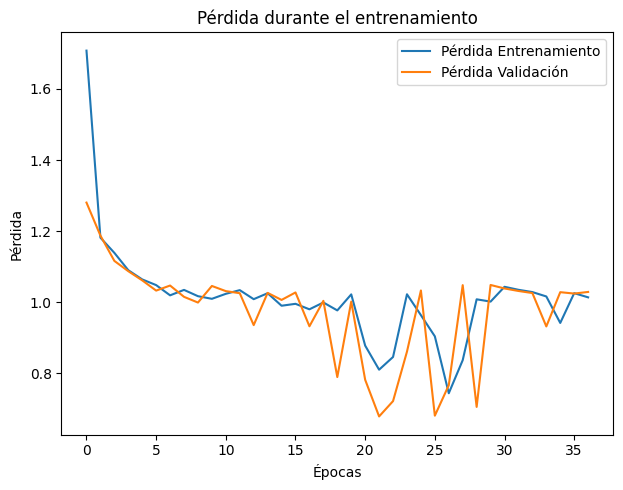

In [20]:
# Graficar la pérdida y la precisión
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_training_history(history)

## Visualizacion de recontrucción

In [21]:
# Generar y medir el tiempo de generación de embeddings
start_time = time.time()
train_embeddings = embedding_model.predict(X_train_tensor, batch_size=32, verbose=1)
test_ae_embeddings = embedding_model.predict(X_test_tensor_ae, batch_size=32, verbose=1)
test_knn_embeddings = embedding_model.predict(X_test_tensor_knn, batch_size=32, verbose=1)
end_time = time.time()

# Verificar las dimensiones del espacio latente
print("\nGeneración de embeddings completada.")
print(f"- Tiempo total de generación: {end_time - start_time:.2f} segundos")
print(f"- Dimensiones de los datos de entrenamiento (X_train): {X_train_tensor.shape}")
print(f"- Dimensiones del espacio latente (embeddings de entrenamiento): {train_embeddings.shape}")
print(f"- Dimensiones del espacio latente (embeddings de prueba): {test_ae_embeddings.shape}")

# Mostrar ejemplo de embeddings
print("\nEjemplo de embeddings de entrenamiento:")
print(train_embeddings[:3])  # Muestra los primeros 5 embeddings


49/49 [==============================] - 0s 492us/step

Generación de embeddings completada.
- Tiempo total de generación: 0.49 segundos
- Dimensiones de los datos de entrenamiento (X_train): (12408, 606)
- Dimensiones del espacio latente (embeddings de entrenamiento): (12408, 20)
- Dimensiones del espacio latente (embeddings de prueba): (1551, 20)

Ejemplo de embeddings de entrenamiento:
[[-0.09735851 -0.15305957 -0.30150548  0.23148929  0.5214603   0.209191
   0.05535244  0.00651332  0.08568033 -0.35727444  0.17863686 -0.11728523
  -0.06612662 -0.15337163 -0.0895032  -0.09936414  0.16707858 -0.0263213
   0.39797145 -0.30065122]
 [ 0.11631812  0.08136865  0.15495917 -0.09816893 -0.49794313 -0.30662987
  -0.16277254  0.01979234 -0.27551696  0.30093542 -0.28229862  0.01856286
   0.03151942  0.11036855 -0.02041617  0.03794518 -0.35698962  0.0772636
  -0.30071276  0.30325624]
 [ 0.08660454  0.09973497  0.19666357 -0.11739232 -0.5306323  -0.28394467
  -0.13203745 -0.00603441 -0.2214748   0

In [22]:
# Reducir el espacio latente a 2 dimensiones usando t-SNE con medición de tiempo
tsne = TSNE(
    n_components=2,  # Reducir a 2 dimensiones
    random_state=42,  # Semilla para reproducibilidad
    perplexity=30,    # Ajustar según el tamaño del dataset (valor típico entre 5 y 50)
    n_iter=1000,      # Aumentar el número de iteraciones para una mejor convergencia
    learning_rate=200,  # Valor típico: entre 10 y 1000
    init='pca'        # Inicialización con PCA para estabilidad
)

# Medir tiempo de ejecución
start_time = time.time()
espacio_latente_2D = tsne.fit_transform(train_embeddings)
end_time = time.time()

# Imprimir tiempo total
print(f"Tiempo de ejecución de t-SNE: {end_time - start_time:.2f} segundos")

Tiempo de ejecución de t-SNE: 16.84 segundos


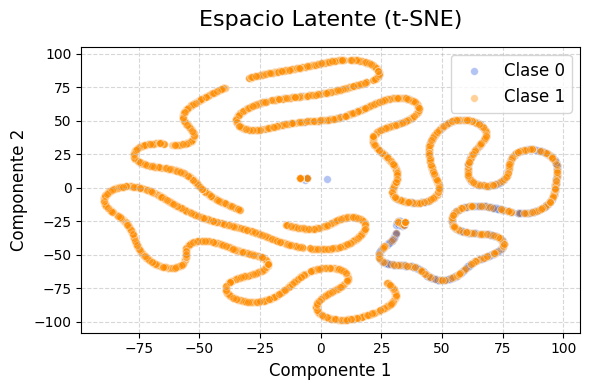

In [23]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(6, 4))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


Ajustando el modelo KNN

Realizando predicciones en el conjunto de prueba...

--- Evaluación del Desempeño ---

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.8432    0.8916    0.8668       766
           1     0.8880    0.8382    0.8624       785

    accuracy                         0.8646      1551
   macro avg     0.8656    0.8649    0.8646      1551
weighted avg     0.8659    0.8646    0.8645      1551


Matriz de Confusión:
[[683  83]
 [127 658]]


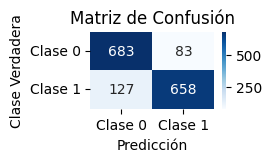

In [24]:
# Ajustar KNN con embeddings de entrenamiento
print("\nAjustando el modelo KNN")
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)
knn.fit(test_ae_embeddings, Y_test)


# Predicciones en conjunto de prueba
print("\nRealizando predicciones en el conjunto de prueba...")
Y_pred = knn.predict(test_knn_embeddings)

# Evaluación de desempeño
print("\n--- Evaluación del Desempeño ---")
print("\nReporte de Clasificación:")
print(classification_report(Y_test_knn, Y_pred, digits=4))  

print("\nMatriz de Confusión:")
conf_matrix = confusion_matrix(Y_test_knn, Y_pred)
print(conf_matrix)

# Visualización de la matriz de confusión (opcional)
plt.figure(figsize=(2, 1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()
